### What is *Self-Reflection* in RAG?

**Self-reflection** means the **LLM (Large Language Model) evaluates and critiques its own answer** before finalizing it — kind of like a human reviewing their work.

It asks itself questions such as:

> “Did I fully answer the question?”
> “Is this reasoning correct?”
> “Do I need to look up more information?”

This step helps improve **accuracy**, **completeness**, and **clarity** in answers.

### Example Conceptually

**Without Reflection:**

> Q: What is RAG in AI?
> A: RAG is a model that combines retrieval and generation.

**With Self-Reflection:**

> Initial Answer: “RAG combines retrieval and generation.”
> Reflection: “This lacks depth—no explanation of why it’s useful.”
> Revised Answer: “RAG (Retrieval-Augmented Generation) enhances LLM accuracy by retrieving relevant external knowledge before generating answers, reducing hallucinations.”

---

In [26]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END
from langchain_community.embeddings import HuggingFaceEmbeddings


In [27]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002692C4D6A40>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002692C4D7250>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Now Lets Make Retreiver

| Step          | Purpose                           | Output        |
| ------------- | --------------------------------- | ------------- |
| 1️⃣ Load data | Read the text file                | `docs`        |
| 2️⃣ Split     | Divide text into small pieces     | `chunks`      |
| 3️⃣ Embed     | Convert chunks to numeric vectors | `embedding`   |
| 4️⃣ Store     | Save vectors in FAISS index       | `vectorstore` |
| 5️⃣ Retrieve  | Search similar chunks             | `retriever`   |


In [28]:
docs = TextLoader("data_science_interview_cleaned.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 971d6bec-8107-4f44-afcc-484352976bac)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


# 2. State Definition


| Field            | Type             | Purpose                                   |
| ---------------- | ---------------- | ----------------------------------------- |
| `question`       | `str`            | User’s question                           |
| `retrieved_docs` | `List[Document]` | Text chunks retrieved from knowledge base |
| `answer`         | `str`            | Generated answer                          |
| `reflection`     | `str`            | Self-evaluation or critique of answer     |
| `revised`        | `bool`           | Whether the answer was improved           |
| `attempts`       | `int`            | Number of times the model tried           |


In [ ]:
class RagReflectionState(BaseModel):# 
    question:str
    retrieved_docs:List[Document]=[]
    answer:str=""
    reflection:str=""
    revised:bool=False
    attempts:int=0


# 3. Nodes

| Step   | Description                                         | Output                       |
| ------ | --------------------------------------------------- | ---------------------------- |
| Input  | Takes current state (`state`)                       | `state.question`             |
| Action | Uses retriever to find relevant text chunks         | `retrieved_docs`             |
| Output | Returns a **new updated state** with retrieved docs | Updated `RagReflectionState` |


In [30]:
# a.  retrieve
def retrieve_docs(state:RagReflectionState) ->RagReflectionState:
    docs=retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs":docs})

| Step | Action                    | Result                                          |
| ---- | ------------------------- | ----------------------------------------------- |
| 1️⃣  | Combine retrieved docs    | `context`                                       |
| 2️⃣  | Build question prompt     | `prompt`                                        |
| 3️⃣  | Generate answer using LLM | `answer`                                        |
| 4️⃣  | Update state              | new `RagReflectionState` with answer + attempts |


In [31]:
# b. generate answer
def generate_answer(state:RagReflectionState) ->RagReflectionState:
    context="\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt=f"""use the following context to answer the question 
context:
{context}
question
{state.question}
"""
    answer=llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer":answer,"attempts":state.attempts + 1})

| Step | Action                  | Output                                     |
| ---- | ----------------------- | ------------------------------------------ |
| 1️⃣  | Prompt LLM to reflect   | `result` (reflection text)                 |
| 2️⃣  | Parse reflection result | `is_ok` boolean                            |
| 3️⃣  | Update state            | Save reflection + mark `revised` if needed |


In [32]:
# c. Self-Reflect
def reflect_on_answer(state:RagReflectionState) ->RagReflectionState:
    prompt=f"""reflect on the following answer to see it fully addresses the question.
    state yes if it is complete and correct, or no with explanation
    question:{state.question}
    answer:{state.answer}
    respond like:
    reflection:YES OR NO
    explanation:......"""
    result=llm.invoke(prompt).content
    is_ok="reflection_yes" in result.lower()
    return state.model_copy(update={"reflection":result,"revised": not is_ok}) 


| Step | Function              | Purpose                        |
| ---- | --------------------- | ------------------------------ |
| a    | `retrieve_docs()`     | Retrieve context               |
| b    | `generate_answer()`   | Generate response              |
| c    | `reflect_on_answer()` | Critique answer                |
| d    | `finalize()`          | Return final structured result |


In [33]:
# d. Finalizer
def finalize(state:RagReflectionState) ->RagReflectionState:
    return state

# 4. LangGraph RAG

| Condition         | Meaning                                        | Next Step                     |
| ----------------- | ---------------------------------------------- | ----------------------------- |
| `not s.revised`   | The reflection said the answer is good (`YES`) | ✅ Finish                      |
| `s.attempts >= 2` | Already tried twice — stop retrying            | ✅ Finish                      |
| Else              | The answer needs improvement                   | 🔁 Go back to `retrieve_docs` |


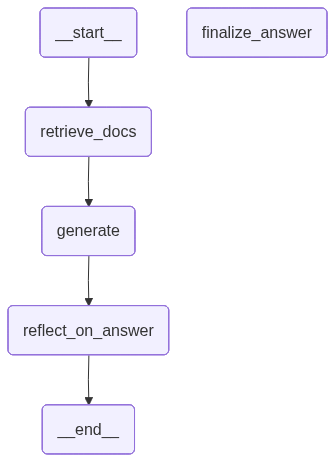

In [34]:
builder=StateGraph(RagReflectionState)

builder.add_node("retrieve_docs",retrieve_docs)
builder.add_node("generate",generate_answer)
builder.add_node("reflect_on_answer",reflect_on_answer)
builder.add_node("finalize_answer",finalize)

builder.set_entry_point("retrieve_docs")
builder.add_edge("retrieve_docs","generate")
builder.add_edge("generate","reflect_on_answer")

builder.add_conditional_edges(
    "reflect_on_answer",
    lambda s:"done" if not s.revised or s.attempts >=2 else "retrieve_docs"
)
builder.add_edge("finalize_answer",END)
graph=builder.compile()
graph

# 5. Run the Agent

In [ ]:
# if __name__ == "__main__": This ensures the code inside this block runs only when the script is executed directly (not imported as a module).
if __name__ == "__main__":
    user_query="what data science means" # input("Enter your question: ")
    init_state=RagReflectionState(question=user_query) # initialize the state
    result=graph.invoke(init_state) # run the graph

    print("\n Final answer",result["answer"]) # print the final answer
    print("\n Reflection log",result["reflection"]) # print the reflection log
    print("\n total attempts",result["attempts"]) # print the number of attempts made

Task reflect_on_answer with path ('__pregel_pull', 'reflect_on_answer') wrote to unknown channel branch:to:done, ignoring it.



 Final answer Based on the provided context, the question about data science is already answered in the background information. However, I can summarize the key points for clarity:

What exactly does the term "Data Science" mean?

Data Science is an interdisciplinary field that combines various scientific procedures, algorithms, tools, and machine learning techniques to uncover patterns and insights from raw input data using statistical and mathematical analysis. It encompasses a range of technologies, including statistics, computer science, machine learning, deep learning, data analysis, data visualization, and more.

In simpler terms, data science involves:

1. Collecting and processing data
2. Applying technical analysis methods to identify patterns
3. Extracting useful insights from the data
4. Presenting the findings in a clear and aesthetically appealing manner

Data science is a critical field in today's job market, with many data scientist roles available worldwide. According 